# Notas de Gonche

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt


import simulator.constants as con

from sklearn.metrics.pairwise import haversine_distances
from math import radians

import geopandas as gpd
from shapely.geometry import Polygon

In [2]:
world_pop_density_file = "/home/minigonche/Dropbox/Projects/synthetic_mobility_data_generator/data/costa_rica-panama/pd_2020_1km_ASCII_XYZ.csv"
populated_places_folder = "/home/minigonche/Dropbox/Projects/synthetic_mobility_data_generator/data/costa_rica-panama/hotosm_populated_places_points_shp"
road_lines_folder = "/home/minigonche/Dropbox/Projects/synthetic_mobility_data_generator/data/costa_rica-panama/hotosm_roads_lines_shp"

In [3]:
# Density
world_pop_density = pd.read_csv(world_pop_density_file)
world_pop_density = gpd.GeoDataFrame(world_pop_density, geometry=gpd.points_from_xy(world_pop_density.X, world_pop_density.Y), crs=con.USUAL_PROJECTION)

# Populated Places
populated_places = gpd.read_file(populated_places_folder)

# Uses Haversine Distance
# (A lot faster than geopandas.distance)
world_pop_density["lon_rad"] = world_pop_density.geometry.x.apply(lambda v : radians(v))
world_pop_density["lat_rad"] = world_pop_density.geometry.y.apply(lambda v : radians(v))

populated_places["lon_rad"] = populated_places.geometry.x.apply(lambda v : radians(v))
populated_places["lat_rad"] = populated_places.geometry.y.apply(lambda v : radians(v))

# Extracts closest city
closest_city = world_pop_density.apply(lambda row : np.argmin(haversine_distances(populated_places[["lat_rad", "lon_rad"]], [[row["lat_rad"], row["lon_rad"]]])[:,0]), axis = 1)

# Groups, sums and assigns
world_pop_density["city"] = closest_city
population = world_pop_density[["Z","city"]].groupby("city").sum()


# Forms the final Frame
populated_places["id"] = populated_places.apply(lambda row : f"{row['name']} - {row.name}", axis = 1)
populated_places["population"] = population
populated_places["lat"] = populated_places.geometry.y
populated_places["lon"] = populated_places.geometry.x



In [4]:
nodes = populated_places[["id","population","lat","lon","geometry"]].copy()
nodes


,id,population,lat,lon,geometry
0,Liberia - 0,58725.820929,10.633340,-85.436272,POINT (-85.43627 10.63334)
1,Tilarán - 1,10366.156730,10.470980,-84.967260,POINT (-84.96726 10.47098)
2,La Fortuna - 2,1934.716064,10.471684,-84.644436,POINT (-84.64444 10.47168)
3,Limón - 3,19242.702255,9.993560,-83.030314,POINT (-83.03031 9.99356)
4,Sixaola - 4,1591.918549,9.505422,-82.614567,POINT (-82.61457 9.50542)
...,...,...,...,...,...
6550,Bajo La Concepción - 6550,275.206904,8.266004,-81.312094,POINT (-81.31209 8.26600)
6551,Alto de La Palma - 6551,314.413401,8.246557,-81.368233,POINT (-81.36823 8.24656)
6552,Agua Viva - 6552,300.897919,8.217208,-81.294220,POINT (-81.29422 8.21721)
6553,El Bongo - 6553,461.659553,7.920442,-80.462811,POINT (-80.46281 7.92044)


In [5]:
def trim_road(geometry, lon_1, lat_1, lon_2, lat_2):
    '''
    Method that trims the given geometry to the endpoints given.
    This method is design to adjust road line strings so that they don't exceed the given endpoints. 
    '''
    # Width of square in kilometer
    kms_width = 1000

    # Extract Normal Vector
    if lon_1 == lon_2:
        N1 = 1
        N2 = 0
    else:
        N2 = -1
        N1 = (lat_2 - lat_1) / (lon_2 - lon_1)

    # Normalizes
    length = np.sqrt(N1**2+N2**2)
    N1 /= length
    N2 /= length

    # Multiplies by size
    N1 *= kms_width/111.32 # 111.32 km is one longitude/latitude near the equator
    N2 *= kms_width/111.32 # 111.32 km is one longitude/latitude near the equator

    # Location 1 point in perpendicular line
    l1_1 = (lon_1 + N1, lat_1 + N2)
    l1_2 = (lon_1 - N1, lat_1 - N2)

    # Location 2 point in perpendicular line
    l2_1 = (lon_2 + N1, lat_2 + N2)
    l2_2 = (lon_2 - N1, lat_2 - N2)

    points = [l1_1, l1_2, l2_2, l2_1]

    # Create a polygon
    polygon = Polygon(points)

    # Create a GeoDataFrame with the polygon
    return geometry.intersection(polygon)


In [6]:
# Reads the file
roads = gpd.read_file(road_lines_folder)
roads = roads[["highway", "geometry"]].copy()

# Creates Intersection
intersection = roads.sjoin(roads)
# Renames
intersection = intersection.reset_index().rename(columns = {"index" : "index_left"})

# Filters out self intersections
intersection = intersection[intersection.index_left != intersection.index_right]
# Filters out roads without same type
intersection = intersection[intersection.highway_left == intersection.highway_right]


# Create an undirected graph and finds connected components to merge
graph = nx.Graph()
graph.add_nodes_from(roads.index.values)
graph.add_edges_from(intersection.apply(lambda row: (row.index_left, row.index_right), axis = 1).values)
components = list(nx.connected_components(graph))

# Assigns the groups / components
i = 0
dfs = []
for comp in components:
    dfs.append(pd.DataFrame({"group" : i},index = list(comp)))
    i += 1

groups = pd.concat(dfs)
roads["group"] = groups['group']

# Dissolves
roads = roads.dissolve(by="group").reset_index(drop = True)


nodes.geometry = nodes.geometry.to_crs(con.MANIPULATION_PROJECTION)
roads.geometry = roads.geometry.to_crs(con.MANIPULATION_PROJECTION)

node_to_road_mapping = nodes.sjoin_nearest(roads)[["id","index_right"]].rename(columns = {"index_right" : "road_index"})

nodes.geometry = nodes.geometry.to_crs(con.USUAL_PROJECTION)
roads.geometry = roads.geometry.to_crs(con.USUAL_PROJECTION)

# Constructs edges
dfs = []
for r in node_to_road_mapping.road_index.unique():

    # Extracts the group
    node_group = node_to_road_mapping[node_to_road_mapping.road_index == r][['id']]
    df = node_group.merge(node_group, how='cross')
    df = df[df.id_x > df.id_y].copy()
    df = df.rename(columns = {"id_x": "node_id1", "id_y": "node_id2"})

    # Assigns value and geometry
    df["value"] = 1
    df["geometry"] = roads.geometry.loc[r]

    dfs.append(df)

edges = pd.concat(dfs, ignore_index = True)
edges = gpd.GeoDataFrame(edges, geometry = "geometry")
 


In [8]:
new_geo = []
for i, edge_row in edges.iterrows():

    sel_nodes = nodes[nodes.id.isin([edge_row.node_id1,edge_row.node_id2])]
    node_1 = sel_nodes.iloc[0]
    node_2 = sel_nodes.iloc[1]
    new_geo.append(trim_road(edge_row.geometry, node_1.lon, node_1.lat, node_2.lon, node_2.lat))

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [7]:
edges

# Trims Geometries
def trim_geometry_from_edge(edge_row):
    sel_nodes = nodes[nodes.id.isin([edge_row.node_id1,edge_row.node_id2])]
    node_1 = sel_nodes.iloc[0]
    node_2 = sel_nodes.iloc[1]
    return trim_road(edge_row.geometry, node_1.lon, node_1.lat, node_2.lon, node_2.lat)

edges.geometry = edges.apply(trim_geometry_from_edge, axis = 1)

,node_id1,node_id2,value,geometry
0,Liberia - 0,Las Pailas - 1041,1,"MULTILINESTRING ((-85.35823 10.76068, -85.3559..."
1,Santa María - 2112,Liberia - 0,1,"MULTILINESTRING ((-85.35823 10.76068, -85.3559..."
2,Santa María - 2112,Las Pailas - 1041,1,"MULTILINESTRING ((-85.35823 10.76068, -85.3559..."
3,La Fortuna - 2,Agua Azul - 248,1,"MULTILINESTRING ((-84.64843 10.47159, -84.6473..."
4,Pilo - 196,La Fortuna - 2,1,"MULTILINESTRING ((-84.64843 10.47159, -84.6473..."
...,...,...,...,...
36012,Quebrada El Calabazo - 6498,El Higo - 6500,1,"MULTILINESTRING ((-80.53451 7.71892, -80.53450..."
36013,El Cedro - 6504,Chupá - 6505,1,"MULTILINESTRING ((-80.41728 7.93569, -80.41744..."
36014,Llano Largo - 6530,Agua Viva - 6552,1,"MULTILINESTRING ((-81.30736 8.21980, -81.30716..."
36015,El Limón - 6543,El Blandito - 6544,1,"MULTILINESTRING ((-81.24802 8.28278, -81.24829..."


: 

: 

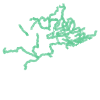

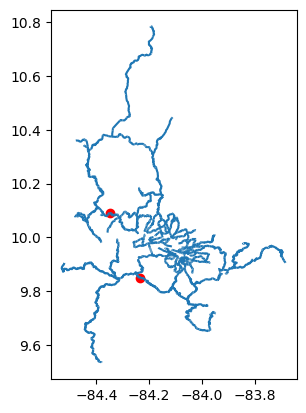

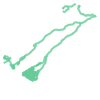

In [16]:
resp = np.array(resp)
resp[:,0]

array([ 1., -1.,  2.,  0.])

In [7]:
# Creates Intersection again to construct graph
intersection = roads.sjoin(roads)
# Renames
intersection = intersection.reset_index().rename(columns = {"index" : "index_left"})

# Filters out self intersections
intersection = intersection[intersection.index_left != intersection.index_right]

# Create an undirected graph and finds connected components to merge
road_graph = nx.Graph()
road_graph.add_nodes_from(roads.index.values)
road_graph.add_edges_from(intersection.apply(lambda row: (row.index_left, row.index_right), axis = 1).values)


In [8]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(15,10))
plt.scatter(nodes.lon, nodes.lat, color='blue', s = 0.1)

plt.show()


<Figure size 1500x1000 with 0 Axes>

In [9]:
for g in roads.group.unique():
    if(len(roads[roads.group == g].highway.unique()) > 1):
        print("error")
print("done")

AttributeError: 'GeoDataFrame' object has no attribute 'group'

In [ ]:
roads = roads.dissolve(by="group").reset_index(drop = True)

,geometry,osm_id,highway
group,,,
0,"MULTILINESTRING ((-84.14531 9.95885, -84.14520...",1.256998e+07,service
1,"MULTILINESTRING ((-84.09124 9.94787, -84.09146...",1.257004e+07,secondary
2,"MULTILINESTRING ((-84.11712 9.94019, -84.11713...",1.257614e+07,trunk_link
3,"MULTILINESTRING ((-84.11646 9.93860, -84.11651...",1.257617e+07,trunk_link
4,"LINESTRING (-84.11648 9.93629, -84.11643 9.936...",1.257625e+07,trunk_link
...,...,...,...
57394,"MULTILINESTRING ((-82.84401 8.69199, -82.84450...",1.037800e+09,bridleway
57395,"MULTILINESTRING ((-82.82806 8.87898, -82.82830...",1.044546e+09,unclassified
57396,"MULTILINESTRING ((-82.90799 8.44169, -82.90794...",1.046631e+09,footway
